(quickstart)=

# ArviZ Quickstart

In [1]:
import arviz as az
import numpy as np

In [ ]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
schools = np.array(
    [
        "Choate",
        "Deerfield",
        "Phillips Andover",
        "Phillips Exeter",
        "Hotchkiss",
        "Lawrenceville",
        "St. Paul's",
        "Mt. Hermon",
    ]
)

## ArviZ style sheets


In [2]:
# ArviZ ships with style sheets!
az.style.use("arviz-darkgrid")

Feel free to check the examples of style sheets {ref}` here <example_styles>`.

## Get started with plotting

ArviZ is designed to be used with libraries like [PyStan](https://pystan.readthedocs.io) and [PyMC3](https://docs.pymc.io), but works fine with raw NumPy arrays.

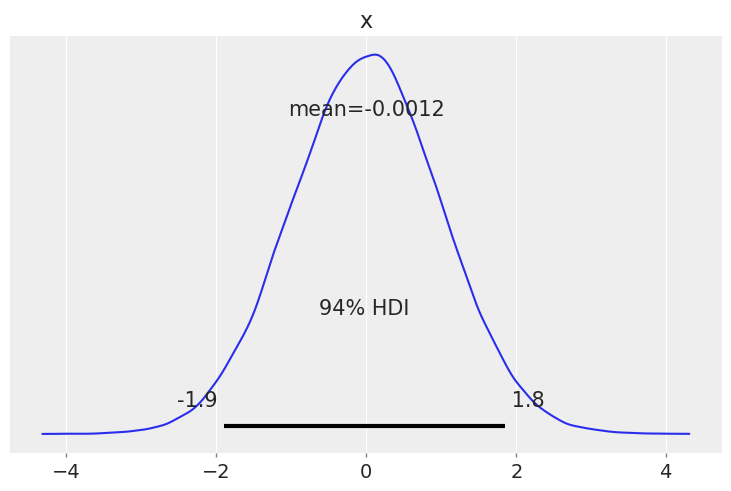

In [3]:
rng = np.random.default_rng()
az.plot_posterior(rng.normal(size=100_000));

Plotting a dictionary of arrays, ArviZ will interpret each key as the name of a different random variable. Each row of an array is treated as an independent series of draws from the variable, called a _chain_. Below, we have 10 chains of 50 draws, each for four different distributions.

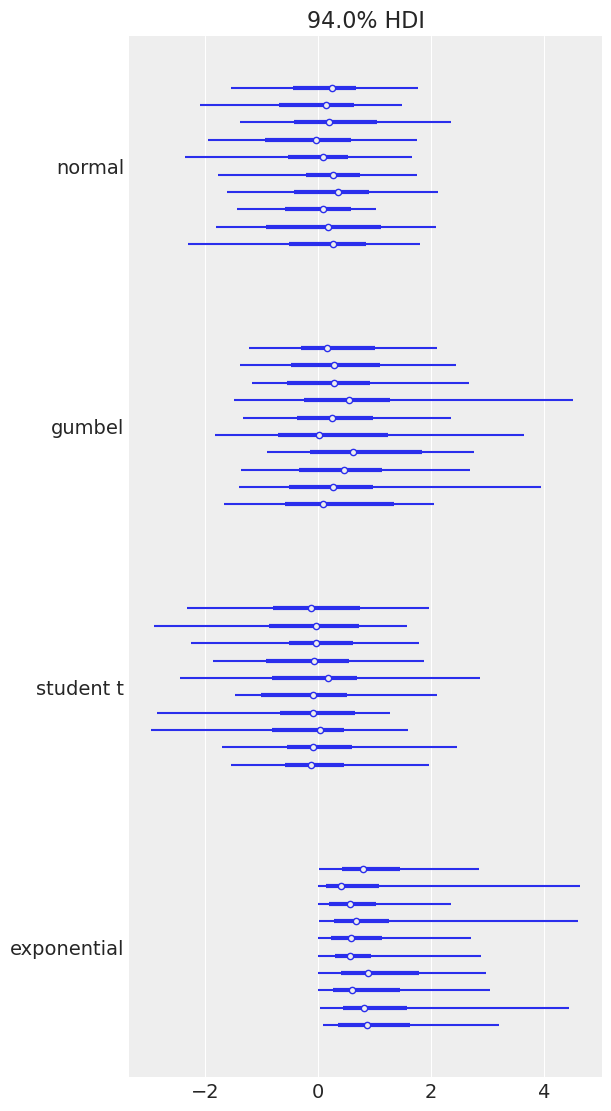

In [4]:
size = (10, 50)
az.plot_forest(
    {
        "normal": rng.normal(size=size),
        "gumbel": rng.gumbel(size=size),
        "student t": rng.standard_t(df=6, size=size),
        "exponential": rng.exponential(size=size),
    }
);

## ArviZ rcParams

You may have noticed that for both {func}`~arviz.plot_posterior` and {func}`~arviz.plot_forest`, the Highest Density Interval (HDI) is 94%, which you may find weird at first. This particular value is a friendly reminder of the arbitrary nature of choosing any single value without further justification, including common values like 95%, 50% and even our own default, 94%. ArviZ includes default values for a few parameters, you can access them with `az.rcParams`. To change the default HDI value to let's say 90% you can do:

In [5]:
az.rcParams["stats.hdi_prob"] = 0.90

## PyMC integration
ArviZ integrates with PyMC. In fact, the object returned by default by most PyMC sampling methods is the {class}`arviz.InferenceData` object.

Therefore, we only need to define a model, sample from it and we can use the result with ArviZ straight away.

In [6]:
import pymc as pm

In [7]:
with pm.Model(coords={"school": schools}) as centered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sigma=tau, dims="school")
    pm.Normal("obs", mu=theta, sigma=sigma, observed=y, dims="school")

    # This pattern can be useful in PyMC
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [mu, obs, tau, theta]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [obs]


Here we have combined the outputs of prior sampling, MCMC sampling to obtain the posterior samples and posterior predictive samples into a single `InferenceData`, the main ArviZ data structure.

The more *groups* it has contains the more powerful analyses it can perform. You can check the `InferenceData` structure specification {ref}`here <schema>`.

:::{tip}
By default, PyMC does not compute the pointwise log likelihood values, which are needed for model comparison with WAIC or PSIS-LOO-CV.
Use `idata_kwargs={"log_likelihood": True}` to have it computed right after sampling for you. Alternatively, you can also use
{func}`pymc.compute_log_likelihood` before calling {func}`~arviz.compare`, {func}`~arviz.loo`, {func}`~arviz.waic` or {func}`~arviz.loo_pit`
:::

In [8]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Below is a "trace plot", a common visualization to check MCMC output and assess convergence. Note that the labeling information we included in the PyMC model via the `coords` and `dims` arguments is kept and added to the plot (it is also available in the InferenceData HTML representation above):

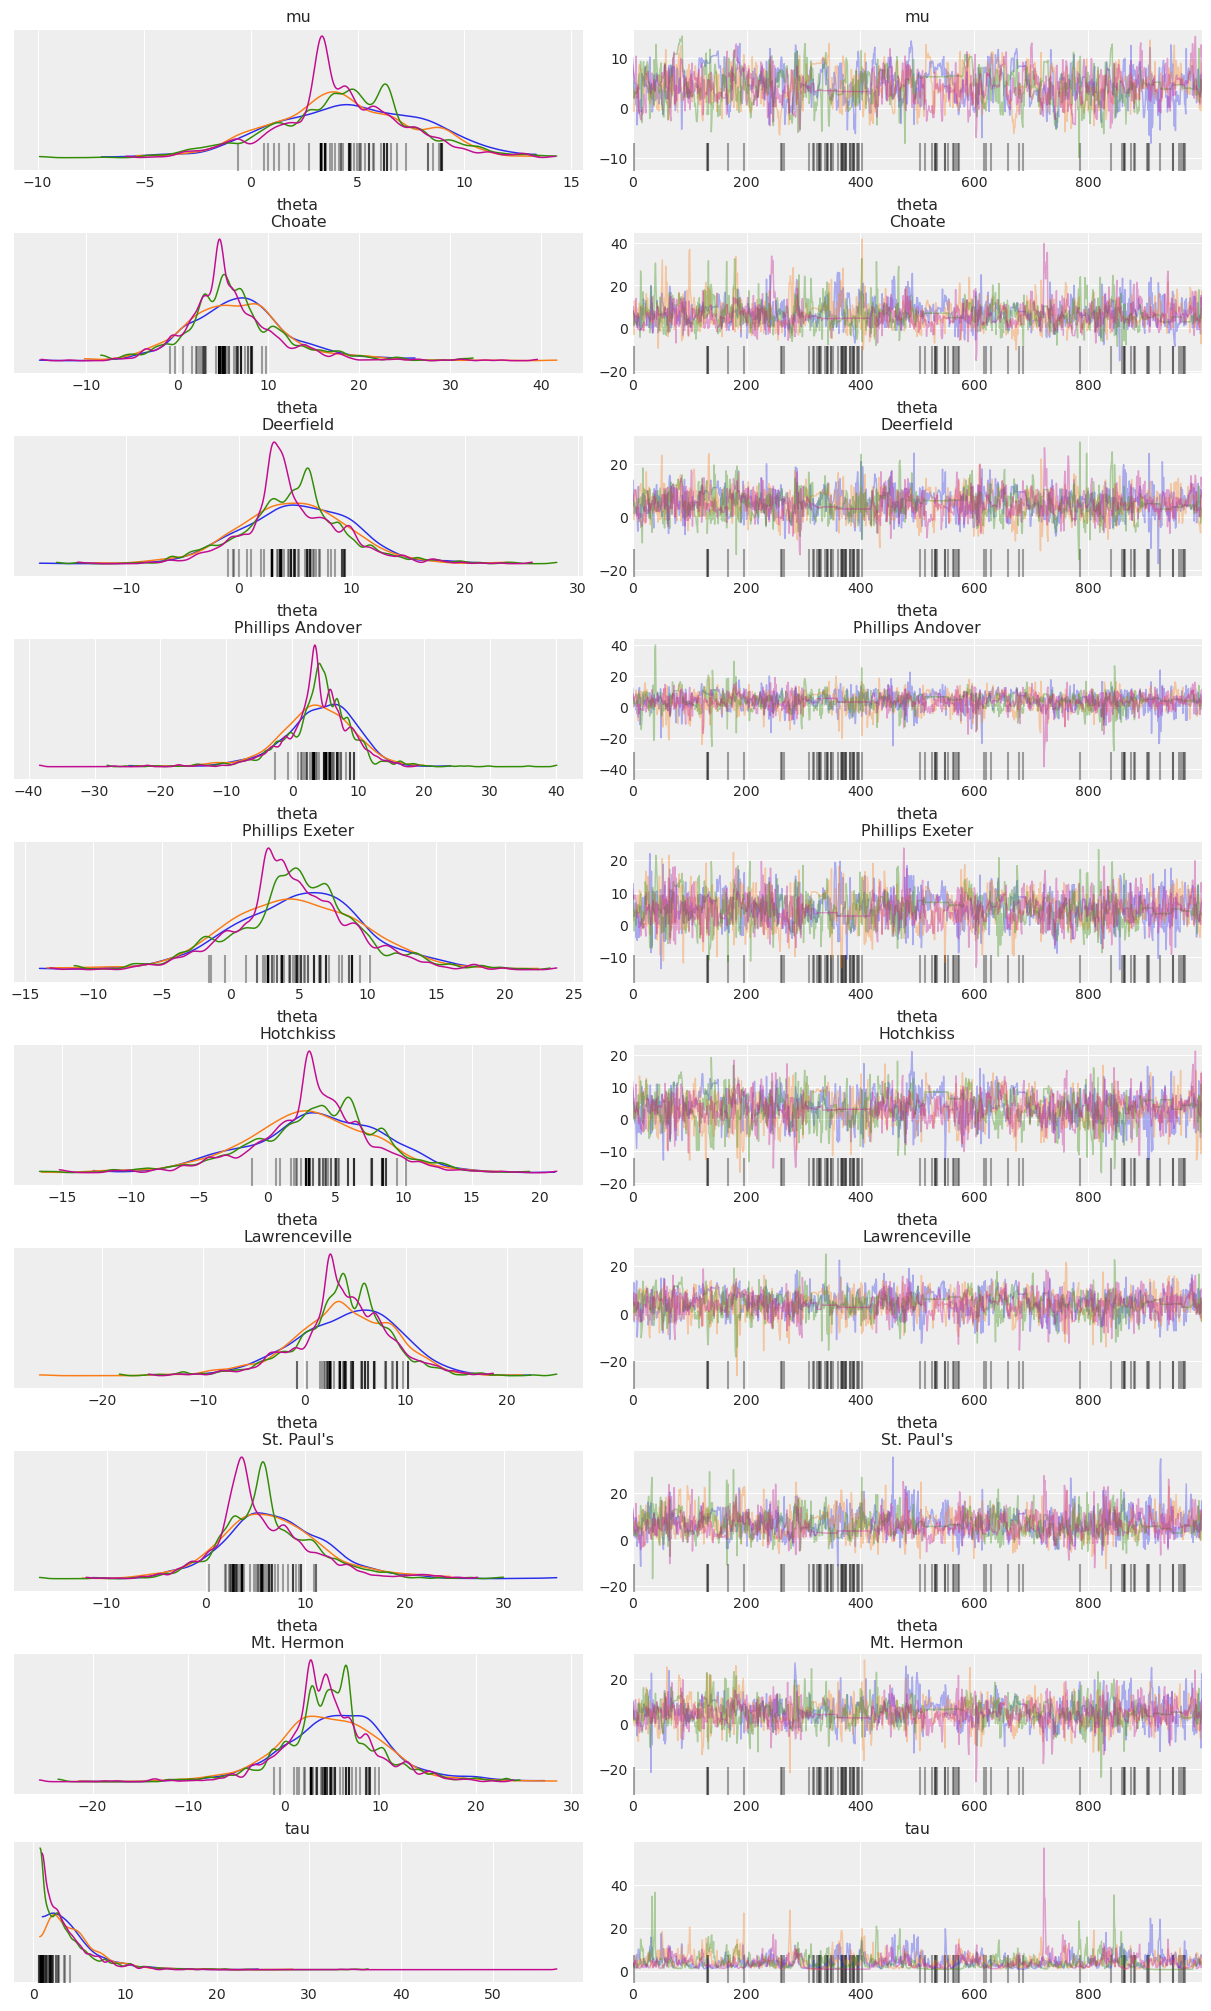

In [9]:
az.plot_trace(idata, compact=False);

## CmdStanPy integration
ArviZ also has first class support for [CmdStanPy](https://mc-stan.org/cmdstanpy/). After creating and sampling a CmdStanPy model:

In [10]:
from cmdstanpy import CmdStanModel
model = CmdStanModel(stan_file="schools.stan")

/home/oriol/bin/miniforge3/envs/general/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
fit = model.sample(data="schools.json")

19:42:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                       | 00:00 Status
chain 2 |                                                                       | 00:00 Status

chain 3 |                                                                       | 00:00 Status


chain 4 |                                                                       | 00:00 Status

chain 3 |███████████████████████████████     | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |███████████████████████████████████████████████████████████| 00:00 Sampling completed

chain 2 |███████████████████████████████████████████████████████████| 00:00 Sampling completed
chain 3 |███████████████████████████████████████████████████████████| 00:00 Sampling completed
chain 4 |███████████████████████████████████████████████████████████| 00:00 Sampling completed


19:42:30 - cmdstanpy - INFO - CmdStan done processing.
19:42:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 27 divergent transitions (2.7%)
	Chain 2 had 9 divergent transitions (0.9%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 20 divergent transitions (2.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


The result can be used for plotting with ArviZ directly:

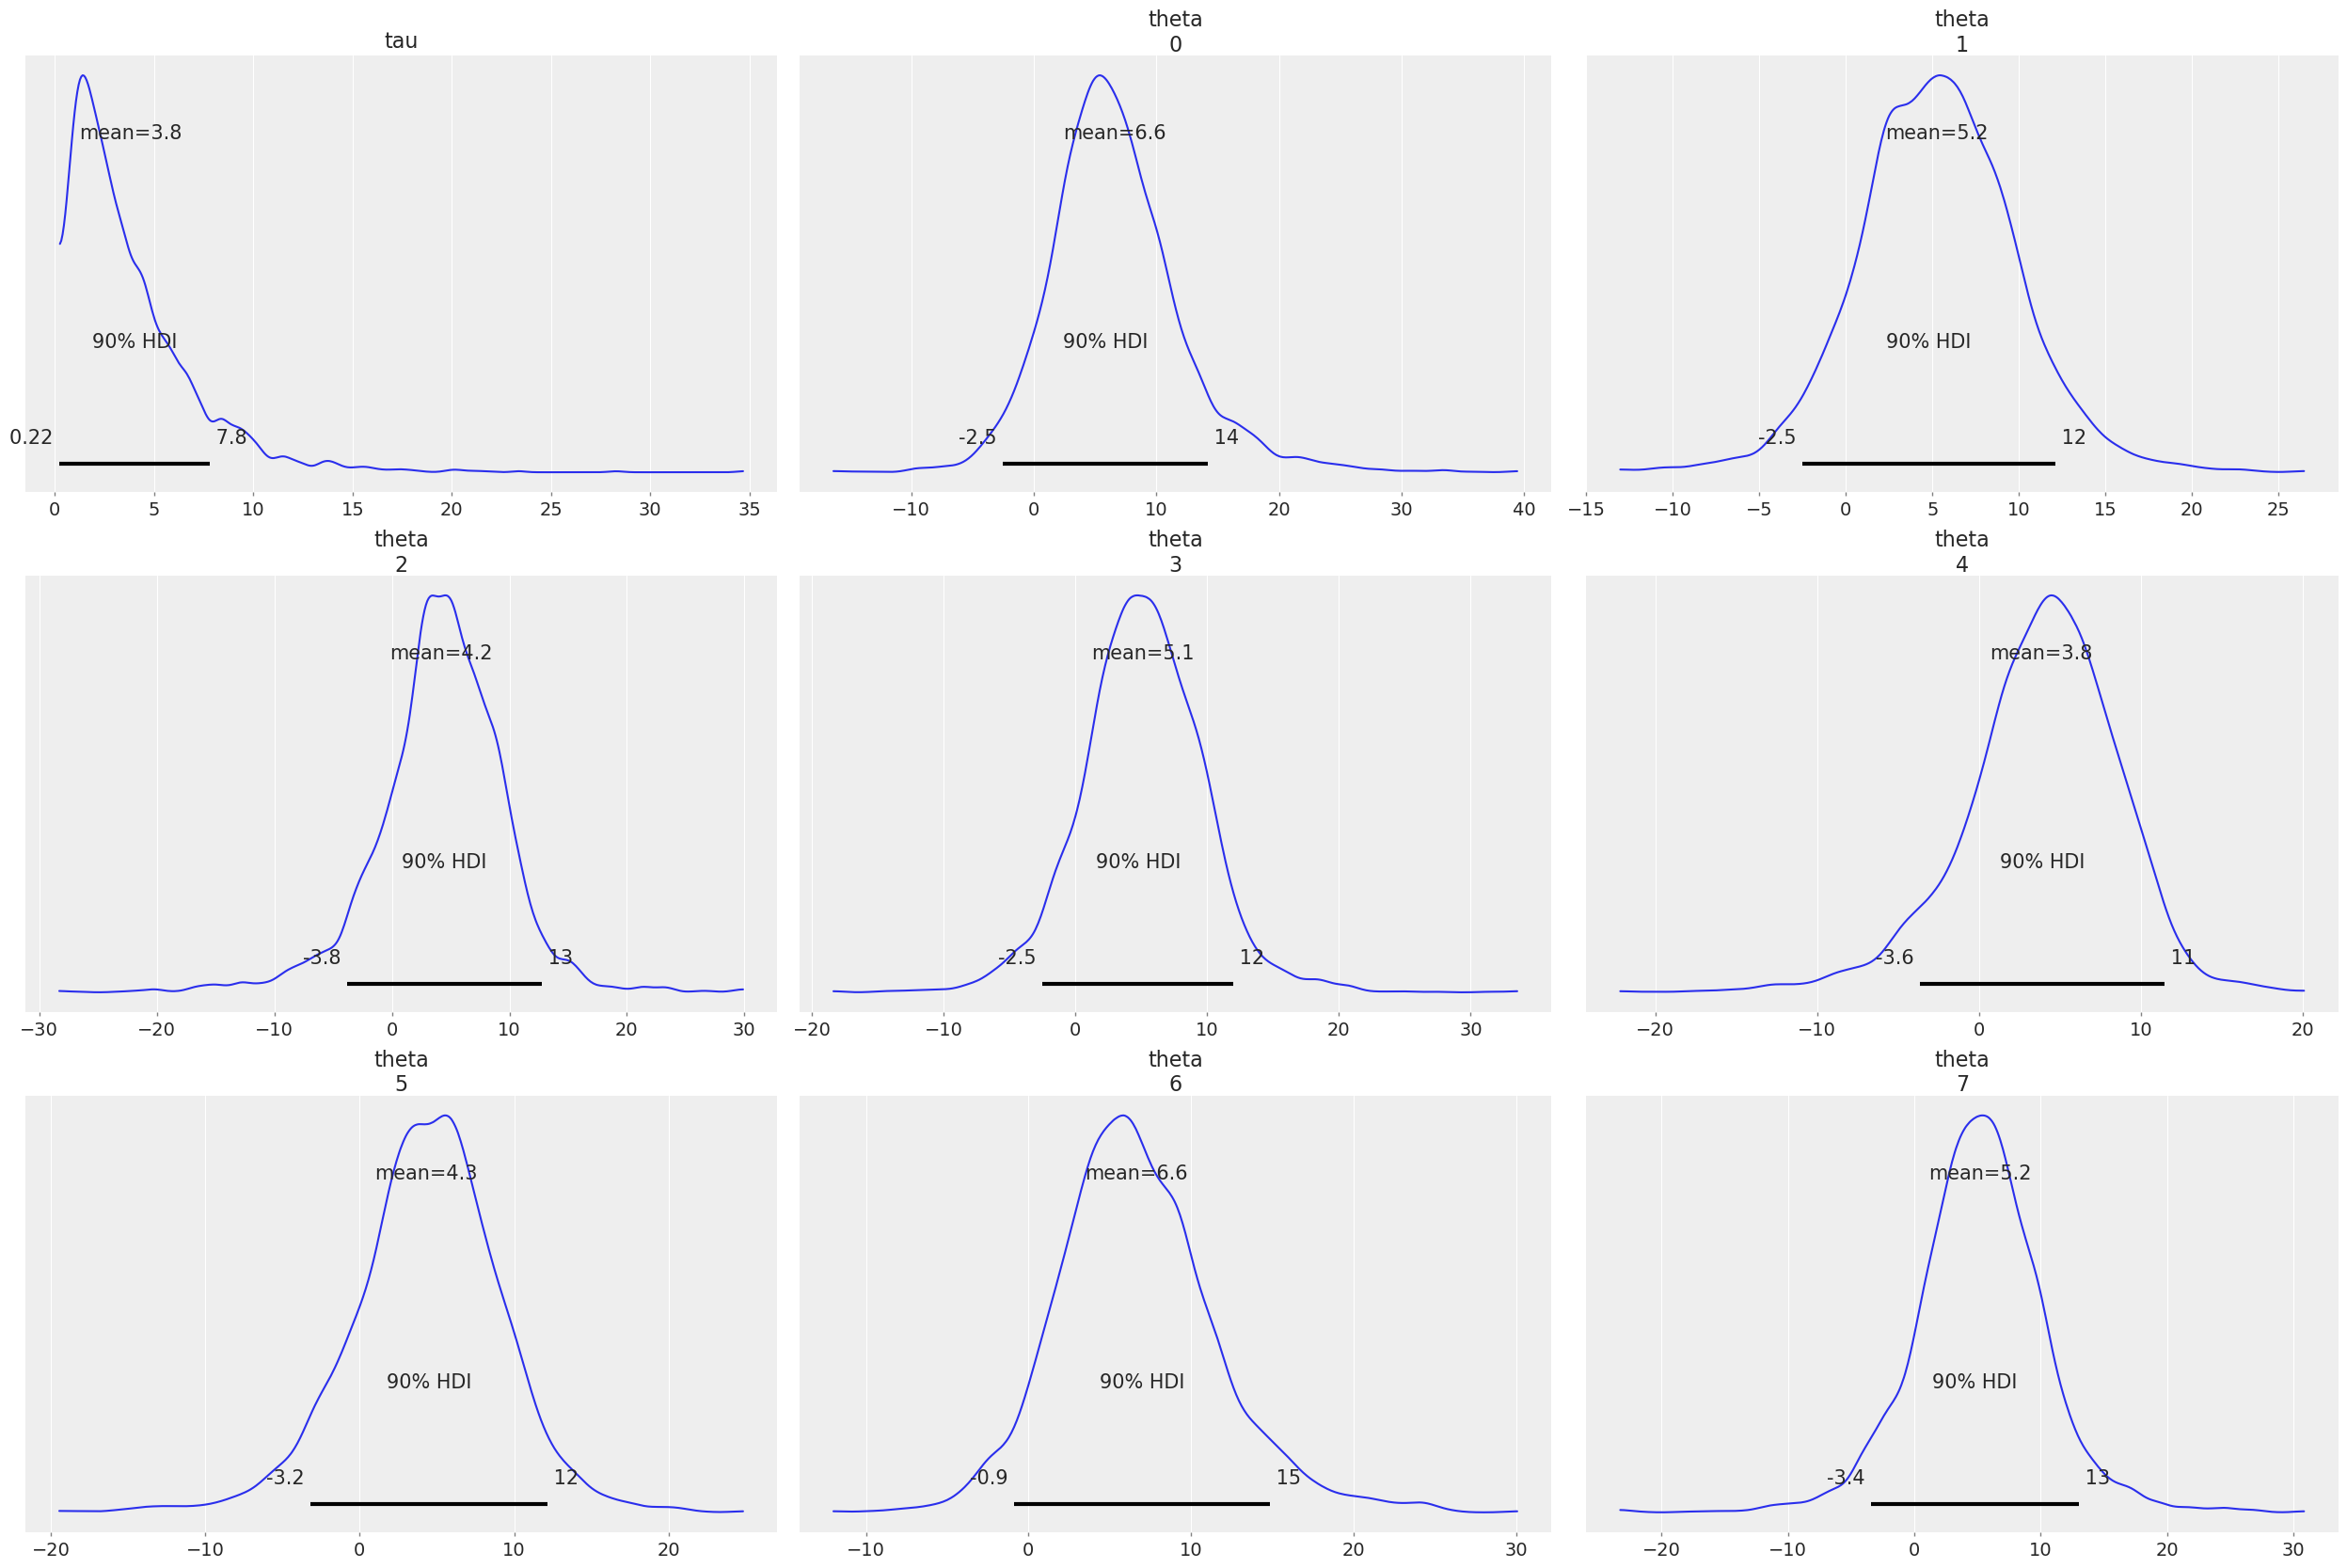

In [15]:
az.plot_posterior(fit, var_names=["tau", "theta"]);

To make the most out of ArviZ however, it is recommended to convert the results to InferenceData.
This will ensure all variables are assigned to the right groups and also gives you the option of labeling the data.

:::{tip}
If ArviZ finds any variable names `log_lik` in the CmdStanPy output, it will interpret them as the pointwise log likelihood values,
in line with the Stan conventions used by the R libraries.
:::

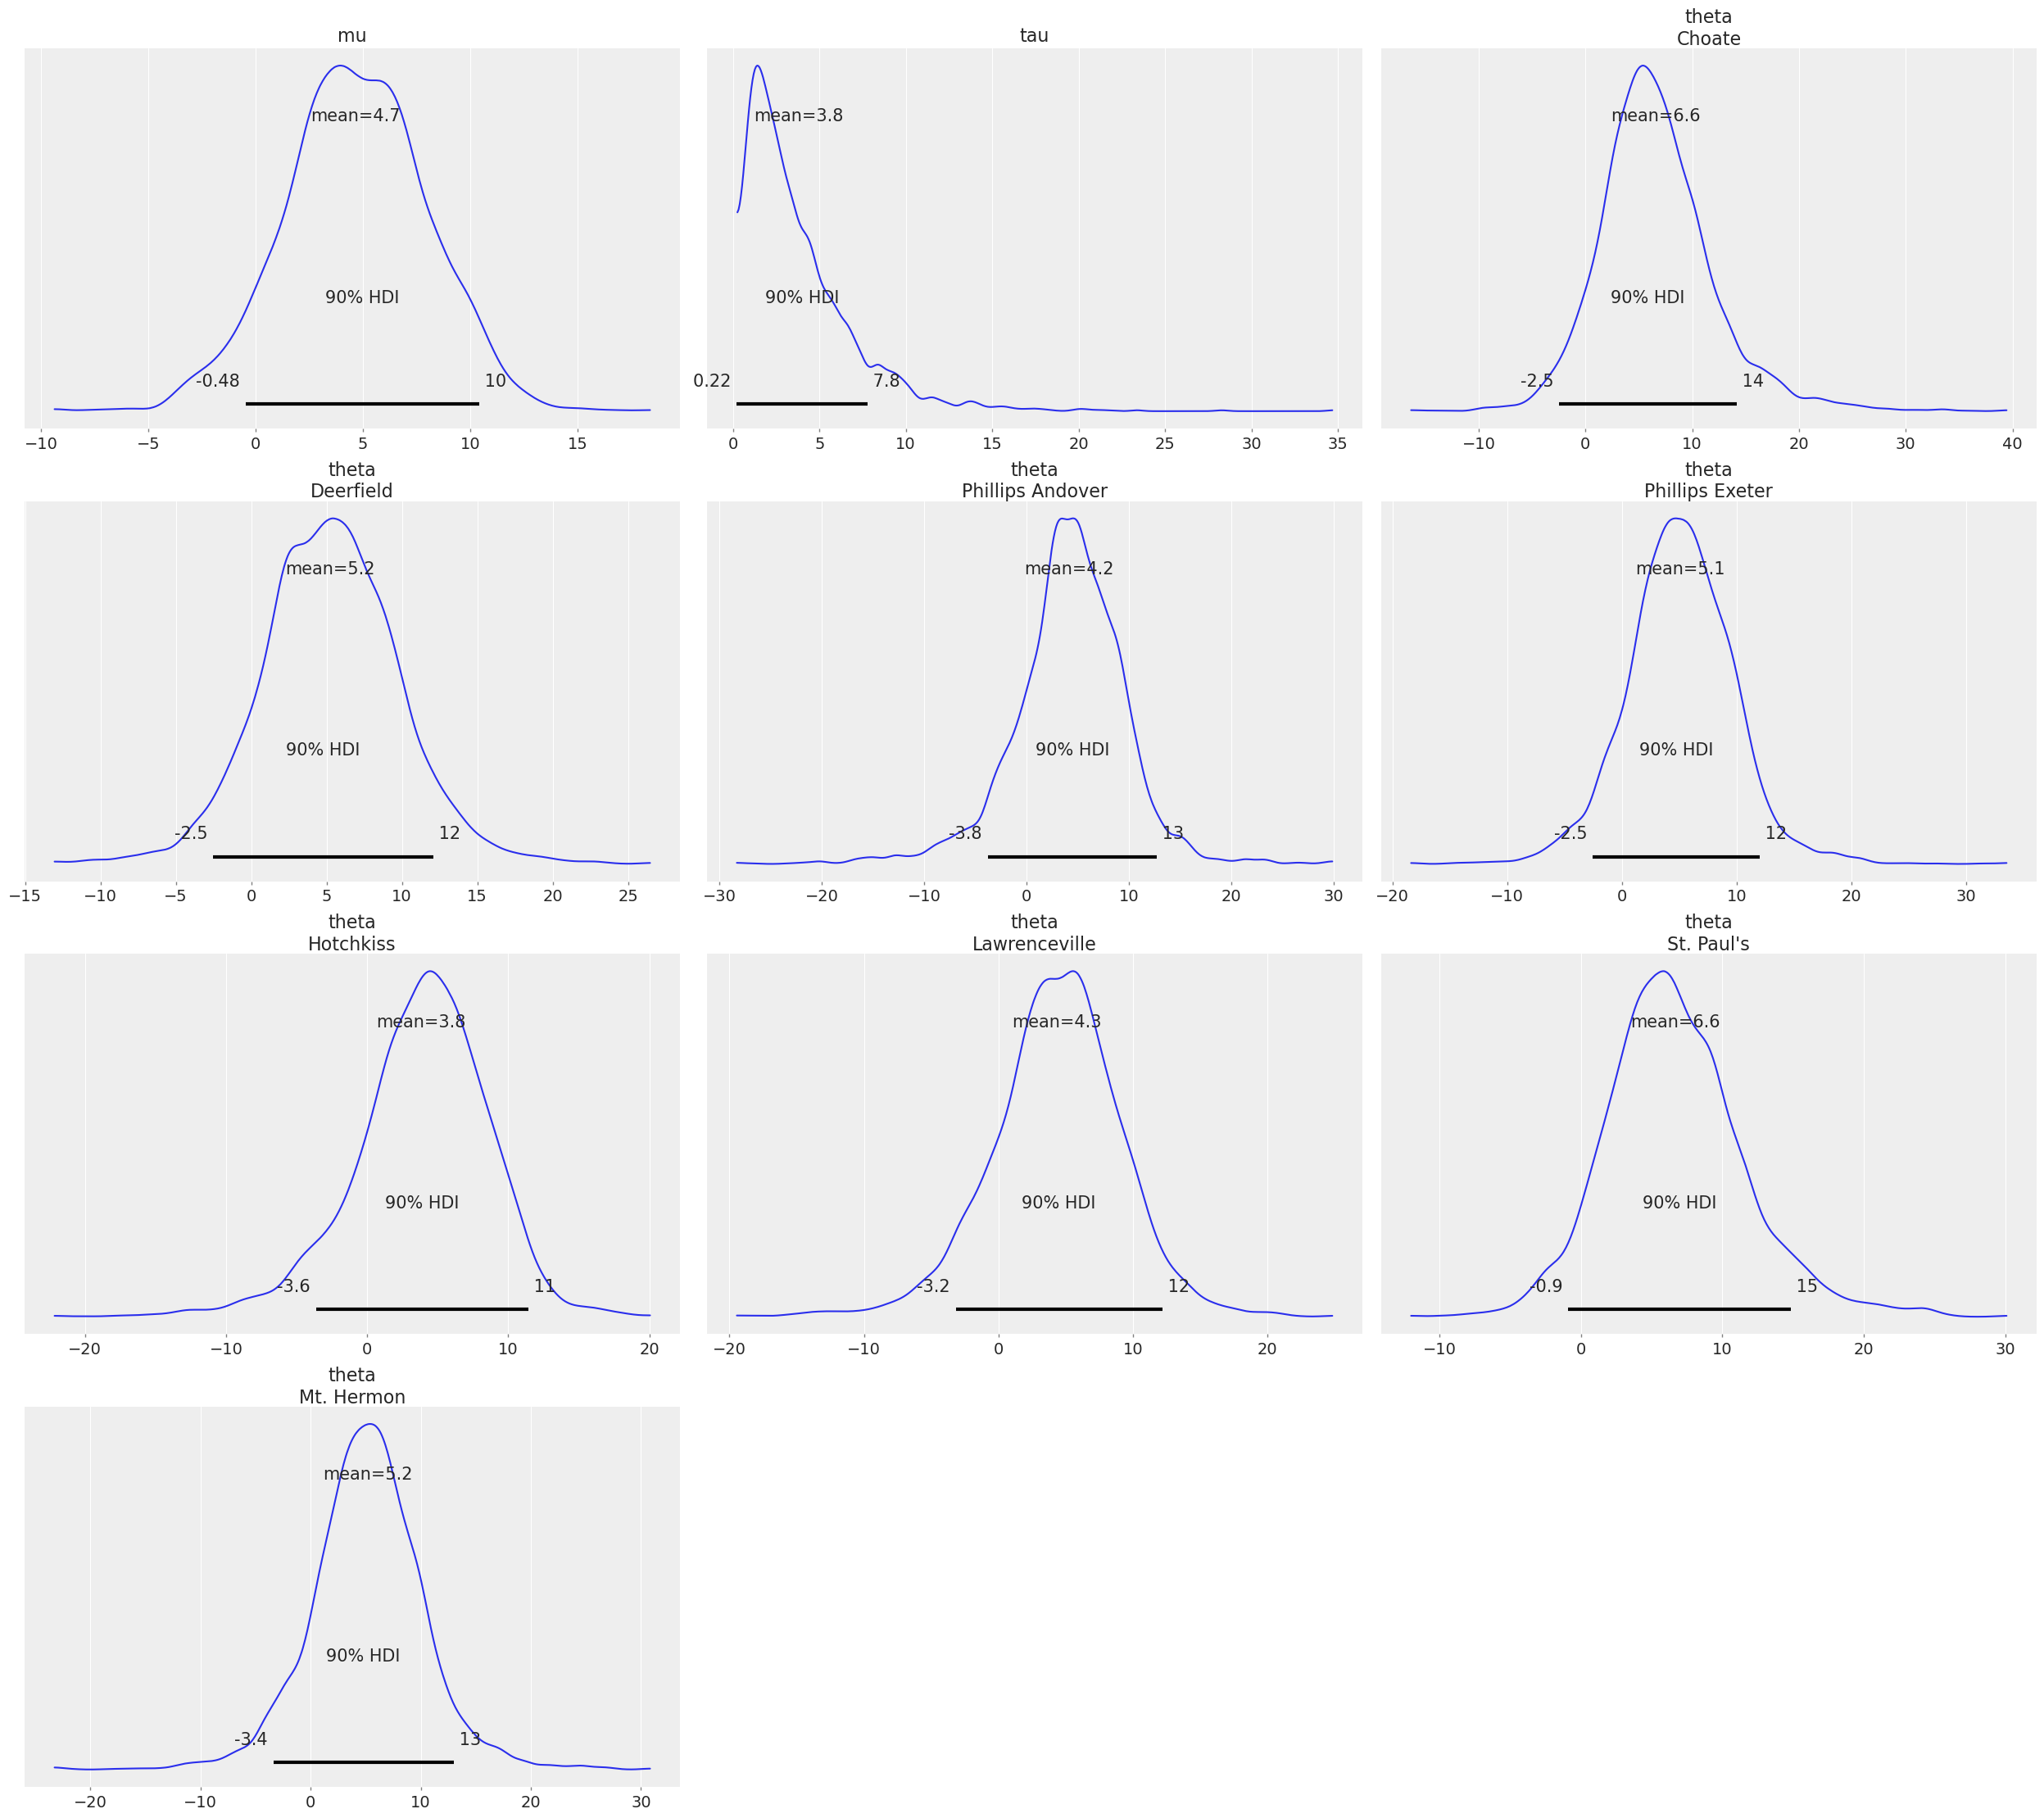

In [17]:
idata = az.from_cmdstanpy(
    fit,
    posterior_predictive="y_hat",
    dims={"y_hat": ["school"], "theta": ["school"]},
    coords={"school": schools}
)
az.plot_posterior(idata, var_names=["tau", "theta"]);

:::{seealso}
creating_InferenceData
working_with_InferenceData
:::